# Introduction to the ELP2000 lunar theory

```{versionadded} 3.2.0

```

Starting from version 3.2.0, heyoka.py provides an implementation of the [ELP2000](https://en.wikipedia.org/wiki/Ephemeride_Lunaire_Parisienne) lunar theory. ELP2000 consists of a set of (large) analytical formulae expressing the geocentric position of the Moon as a function of time. Because the ELP2000 theory is expressed as a set of analytical, differentiable formulae, it can be implemented in heyoka.py's expression system and it can thus be used in the formulation of differential equations.

## API overview

heyoka.py provides two functions to generate the analytical formulae for the ELP2000 theory. These functions are available in the ``model`` submodule.

The first one, ``elp2000_cartesian_e2000()``, returns the time-dependent formulae for the geocentric Cartesian coordinates $\left( x, y, z \right)$ of the Moon referred to the inertial mean ecliptic and equinox of J2000.

The second one, ``elp2000_cartesian_fk5()``, returns the time-dependent formulae for the geocentric Cartesian coordinates $\left( x, y, z \right)$ of the Moon referred to the mean equator and rotational mean equinox of J2000 (i.e., in the FK5 frame). Note that the FK5 frame has been superseded by the [International Celestial Reference Frame (ICRF)](https://en.wikipedia.org/wiki/International_Celestial_Reference_System_and_Frame) in recent years, but for most practical purposes FK5 and ICRF can be considered equivalent (the difference should amount to a few centimeters at the average lunar distance).

In both functions, the unit of measure for the Cartesian coordinates is kilometers.

## Precision and truncation threshold

The ELP2000 solution is formulated as large Fourier/Poisson series whose numerical coefficients decay exponentially. When using the full ELP2000 solution, the precision with respect to high-accuracy numerical integrations is roughly at the centimeter level. By dropping the smaller terms from the series, the precision of the theory degrades but computational efficiency greatly increases. See the [ELP2000 readme](https://ftp.imcce.fr/pub/ephem/moon/elp82b/elp82b.ps) for more details and estimates of the precision at various truncation levels.

By default, all ``elp2000_*()`` functions filter out from the solution terms whose numerical coefficients have a magnitude smaller than $10^{-6}$. This corresponds to an accuracy of a few kilometers on the Cartesian position of the Moon. The truncation threshold can be changed via the ``thresh`` keyword argument:

In [1]:
import heyoka as hy

for thr in [1e-5, 1e-6, 1e-7]:
    print(
        "Size of the solution for x @ {}: {}".format(
            thr, len(hy.model.elp2000_cartesian_fk5(thresh=thr)[0])
        )
    )

Size of the solution for x @ 1e-05: 136564701
Size of the solution for x @ 1e-06: 1779507975
Size of the solution for x @ 1e-07: 582310757046


## Time coordinate

ELP2000 uses [barycentric dynamical time (TDB)](https://en.wikipedia.org/wiki/Barycentric_Dynamical_Time), expressed in Julian centuries from J2000 (JD2451545.0). Note than one Julian year = 365.25 days.

By default, all ``elp2000_*()`` functions use ``hy.time`` to represent the time variable in the ELP2000 formulae. This means that, by default, when the ELP2000 solution is used in an ODE system, time is assumed to be measured in hundreds of Julian years of TDB and $t = 0$ corresponds to the Julian date $2451545.0$:

In [2]:
print(
    "x coordinate, threshold = 1e-2, default time expression:\n{}\n".format(
        hy.model.elp2000_cartesian_fk5(thresh=1e-2)[0]
    )
)

x coordinate, threshold = 1e-2, default time expression:
((((1.0000000000000000 - (2.0000000000000000 * ((1.0180391000000000e-05 + ((4.7020439000000000e-07 + (((((4.6348599999999997e-15 * t) - 2.5079480000000001e-12) * t) - 5.4173670000000002e-10) * t)) * t)) * t)**2.0000000000000000)) * (((385000.52898680314 - (20905.355043242522 * cos((2.3555558982657985 + ((8328.6914269553617 + ((0.00015702775761561094 + ((2.5041111442988642e-07 - (1.1863390776750345e-09 * t)) * t)) * t)) * t))))) * cos((0.089502610822944473 * sin((1.6279052333714679 + ((8433.4661581308319 + (((((2.0216730502267650e-11 * t) - 4.9499476841283623e-09) * t) - 5.9392100004323707e-05) * t)) * t)))))) * cos(((3.8103444305883079 + ((8399.6847317739157 + ((((3.2017095500473753e-08 - (1.5363745554361197e-10 * t)) * t) - 2.8547283984772807e-05) * t)) * t)) + (0.10975980920796485 * sin((2.3555558982657985 + ((8328.6914269553617 + ((0.00015702775761561094 + ((2.5041111442988642e-07 - (1.1863390776750345e-09 * t)) * t)) * t)) * 

It is possible to change the expression used to represent the time variable in the ELP2000 solution via the ``time_expr`` keyword argument. This allows to rescale and change the origin of time in the ELP2000 formulae.

For instance, if we want time to be measured in Julian days (rather than centuries) since J2000, we can write:

In [3]:
print(
    "x coordinate, threshold = 1e-2, time in days since J2000:\n{}\n".format(
        hy.model.elp2000_cartesian_fk5(time_expr=hy.time / 36525.0, thresh=1e-2)[0]
    )
)

x coordinate, threshold = 1e-2, time in days since J2000:
((((1.0000000000000000 - (2.0000000000000000 * ((1.0180391000000000e-05 + ((4.7020439000000000e-07 + (((((4.6348599999999997e-15 * (2.7378507871321012e-05 * t)) - 2.5079480000000001e-12) * (2.7378507871321012e-05 * t)) - 5.4173670000000002e-10) * (2.7378507871321012e-05 * t))) * (2.7378507871321012e-05 * t))) * (2.7378507871321012e-05 * t))**2.0000000000000000)) * (((385000.52898680314 - (20905.355043242522 * cos((2.3555558982657985 + ((8328.6914269553617 + ((0.00015702775761561094 + ((2.5041111442988642e-07 - (1.1863390776750345e-09 * (2.7378507871321012e-05 * t))) * (2.7378507871321012e-05 * t))) * (2.7378507871321012e-05 * t))) * (2.7378507871321012e-05 * t)))))) * cos((0.089502610822944473 * sin((1.6279052333714679 + ((8433.4661581308319 + (((((2.0216730502267650e-11 * (2.7378507871321012e-05 * t)) - 4.9499476841283623e-09) * (2.7378507871321012e-05 * t)) - 5.9392100004323707e-05) * (2.7378507871321012e-05 * t))) * (2.737850

In a similar fashion, we can change the origin of the time coordinate by adding/subtracting an offset to ``hy.time``. For instance, if we want to be able to use directly the Julian date as time variable (rather than the number of Julian days since J2000), we can write:

In [4]:
print(
    "x coordinate, threshold = 1e-2, time in JD:\n{}\n".format(
        hy.model.elp2000_cartesian_fk5(
            time_expr=(hy.time - 2451545.0) / 36525.0, thresh=1e-2
        )[0]
    )
)

x coordinate, threshold = 1e-2, time in JD:
((((1.0000000000000000 - (2.0000000000000000 * ((1.0180391000000000e-05 + ((4.7020439000000000e-07 + (((((4.6348599999999997e-15 * (2.7378507871321012e-05 * (t - 2451545.0000000000))) - 2.5079480000000001e-12) * (2.7378507871321012e-05 * (t - 2451545.0000000000))) - 5.4173670000000002e-10) * (2.7378507871321012e-05 * (t - 2451545.0000000000)))) * (2.7378507871321012e-05 * (t - 2451545.0000000000)))) * (2.7378507871321012e-05 * (t - 2451545.0000000000)))**2.0000000000000000)) * (((385000.52898680314 - (20905.355043242522 * cos((2.3555558982657985 + ((8328.6914269553617 + ((0.00015702775761561094 + ((2.5041111442988642e-07 - (1.1863390776750345e-09 * (2.7378507871321012e-05 * (t - 2451545.0000000000)))) * (2.7378507871321012e-05 * (t - 2451545.0000000000)))) * (2.7378507871321012e-05 * (t - 2451545.0000000000)))) * (2.7378507871321012e-05 * (t - 2451545.0000000000))))))) * cos((0.089502610822944473 * sin((1.6279052333714679 + ((8433.46615813083

Note that the time expression passed to the ``elp2000_*()`` functions does not need to be based on ``hy.time`` - in fact *any* expression can be used as a time coordinate in the ELP2000 formulae:

In [5]:
print(
    "x coordinate, threshold = 1e-2, time represented as variable 'y':\n{}\n".format(
        hy.model.elp2000_cartesian_fk5(time_expr=hy.expression("y"), thresh=1e-2)[0]
    )
)

x coordinate, threshold = 1e-2, time represented as variable 'y':
((((1.0000000000000000 - (2.0000000000000000 * ((1.0180391000000000e-05 + ((4.7020439000000000e-07 + (((((4.6348599999999997e-15 * y) - 2.5079480000000001e-12) * y) - 5.4173670000000002e-10) * y)) * y)) * y)**2.0000000000000000)) * (((385000.52898680314 - (20905.355043242522 * cos((2.3555558982657985 + ((8328.6914269553617 + ((0.00015702775761561094 + ((2.5041111442988642e-07 - (1.1863390776750345e-09 * y)) * y)) * y)) * y))))) * cos((0.089502610822944473 * sin((1.6279052333714679 + ((8433.4661581308319 + (((((2.0216730502267650e-11 * y) - 4.9499476841283623e-09) * y) - 5.9392100004323707e-05) * y)) * y)))))) * cos(((3.8103444305883079 + ((8399.6847317739157 + ((((3.2017095500473753e-08 - (1.5363745554361197e-10 * y)) * y) - 2.8547283984772807e-05) * y)) * y)) + (0.10975980920796485 * sin((2.3555558982657985 + ((8328.6914269553617 + ((0.00015702775761561094 + ((2.5041111442988642e-07 - (1.1863390776750345e-09 * y)) * y))

## Checking the implementation

In order to check the correctness of heyoka.py's implementation of the ELP2000 theory, we are going to use the [NASA HORIZONS service](https://ssd.jpl.nasa.gov/?horizons) via the [Astroquery](https://astroquery.readthedocs.io/en/latest/) package. Our objective is to compare the lunar positions computed by ELP2000 at different threshold levels with those computed by HORIZONS. On the heyoka.py side, we will be using [compiled functions](<./compiled_functions.ipynb>) to evaluate the ELP2000 series.

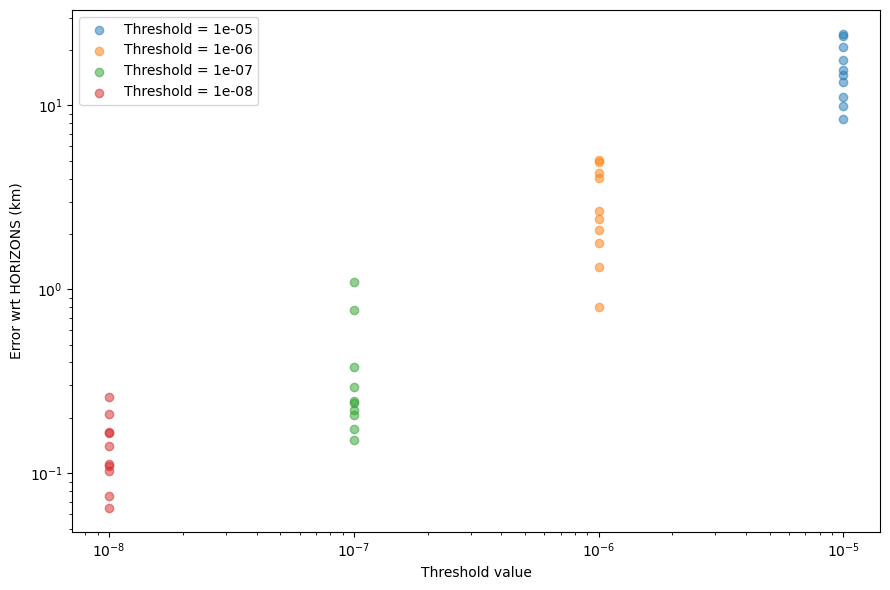

In [6]:
%matplotlib inline
from matplotlib.pylab import plt
import numpy as np
from astroquery.jplhorizons import Horizons
import heyoka as hy

# Setup the plot.
fig = plt.figure(figsize=(9, 6))
plt.xscale("log")
plt.yscale("log")

# Create a heyoka variable for representing time.
tm = hy.make_vars("tm")

# Threshold levels at which we will be computing
# the ELP2000 solution.
thr_values = [1e-5, 1e-6, 1e-7, 1e-8]

# We will perform 10 evaluations of the
# position of the Moon in the 10 years following
# J2000.
dates = np.linspace(2451545.0, 2451545.0 + 365 * 10, 10)

for thr in thr_values:
    # Build the ELP2000 formulae for the geocentric Cartesian
    # position of the Moon in the FK5 frame. Replace the
    # default time variable and set a custom threshold level.
    moon_x, moon_y, moon_z = hy.model.elp2000_cartesian_fk5(
        time_expr=(tm - 2451545.0) / 36525.0, thresh=thr
    )

    # Compile the function for the evaluation of moon_x/y/z.
    moon_cf = hy.cfunc([moon_x, moon_y, moon_z], [tm], compact_mode=True)

    # Run the evaluation.
    elp2000_states = moon_cf(dates.reshape((1, -1)))

    # HORIZONS query:
    # - 301 is the ID of the Moon,
    # - 500@399 is the observer's location,
    #   the centre of the Earth.
    q = Horizons("301", location="500@399", epochs=dates)
    # Convert the HORIZONS query to the ICRF
    # and extract the cartesian position vector.
    tab = q.vectors(refplane="earth")
    hor_x = tab["x"].quantity[:].value
    hor_y = tab["y"].quantity[:].value
    hor_z = tab["z"].quantity[:].value

    hor_states = np.array([hor_x, hor_y, hor_z])

    # Plot the difference (in km) between the positions computed
    # by ELP2000 and HORIZONS.
    AU = 149597870.7
    plt.scatter(
        [thr] * len(dates),
        np.linalg.norm(elp2000_states - hor_states * AU, axis=0),
        alpha=0.5,
        label="Threshold = {}".format(thr),
    )

# Finish setting up the plot.
plt.legend()
plt.xlabel("Threshold value")
plt.ylabel("Error wrt HORIZONS (km)")
plt.tight_layout();

We can see how ELP2000 matches up well with respect to HORIZONS, and how lower truncation levels indeed increase the precision of the ELP2000 solution.

## Limitations and caveats

Like most analytical theories, ELP2000 excels at high thresholds (i.e., low precisions), where it provides compact formulae that can be evaluated quickly. As the precision increases, the solution becomes exponentially longer and more computationally expensive to evaluate and thus less appealing from the point of view of astrodynamical applications.